In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Spring\'23/CSCE670/Animendations/
!ls

/content/drive/MyDrive/Spring'23/CSCE670/Animendations
'Animendations: Project Preview.gslides'
 data
 Gojo
 preprocessed_data
'Project Proposal: Animendations.gdoc'
 synopsis_embeddings
 user_profile
 visual_embeddings


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import ast

animes_data_path = "./preprocessed_data/new_preprocessed_animes.csv"
profiles_data_path = "./preprocessed_data/preprocessed_profiles.csv"
reviews_data_path = "./preprocessed_data/new_preprocessed_reviews.csv"

In [4]:
animes_data = pd.read_csv(animes_data_path)
profiles_data = pd.read_csv(profiles_data_path)
reviews_data = pd.read_csv(reviews_data_path, engine='python', sep=',', error_bad_lines=False)

<ipython-input-4-39739bd06a7d>:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  reviews_data = pd.read_csv(reviews_data_path, engine='python', sep=',', error_bad_lines=False)


In [5]:
animes = animes_data.copy()
profiles = profiles_data.copy()
reviews = reviews_data.copy()

In [6]:
from scipy.sparse import coo_matrix
import torch
import torch.nn as nn
import numpy as np

np.random.seed(0)
unique_AnimeID = reviews['anime_uid'].unique()
unique_users = reviews['profile'].unique()
j = 0
user_old2new_id_dict = dict()
for u in unique_users:
    user_old2new_id_dict[u] = j
    j += 1
j = 0
movie_old2new_id_dict = dict()
for i in unique_AnimeID:
    movie_old2new_id_dict[i] = j
    j += 1
    
# Then, use the generated dictionaries to reindex UserID and MovieID in the data_df
user_list = reviews['profile'].values
movie_list = reviews['anime_uid'].values
for j in range(len(reviews)):
    user_list[j] = user_old2new_id_dict[user_list[j]]
    movie_list[j] = movie_old2new_id_dict[movie_list[j]]
reviews['profile'] = user_list
reviews['anime_uid'] = movie_list

# generate train_df with 70% samples and test_df with 30% samples, and there should have no overlap between them.
train_index = np.random.random(len(reviews)) <= 0.7
train_df = reviews[train_index]
test_df = reviews[~train_index]

# generate train_mat and test_mat
num_user = len(reviews['profile'].unique())
num_items = len(reviews['anime_uid'].unique())

train_mat = coo_matrix((train_df['score'].values, (train_df['profile'].values, train_df['anime_uid'].values)), shape=(num_user, num_items)).astype(float).toarray()
test_mat = coo_matrix((test_df['score'].values, (test_df['profile'].values, test_df['anime_uid'].values)), shape=(num_user, num_items)).astype(float).toarray()

## Matrix Factorization using Funk's SVD

In [7]:
# latent_factors_list = [10, 30, 50, 100]
latent_factors_list = [30]
# lr_list = [0.0001, 0.001, 0.01, 0.1]
lr_list = [0.001]
reg_list = [1e-01]
num_epochs = 30

for latent_factors in latent_factors_list:
  for lr in lr_list:
    for reg in reg_list:
      print("-----------------------{}---{}---{}---------------------------".format(latent_factors, lr, reg))
      P = np.random.rand(num_user, latent_factors)
      Q = np.random.rand(num_items, latent_factors)

      train_loss = []
      test_loss = []
      nonzero_indices_train = np.nonzero(train_mat)
      nonzero_indices_test = np.nonzero(test_mat)

      for epoch in range(num_epochs):
          for u in range(num_user):
              for i in range(num_items):
                  if train_mat[u, i] > 0:
                    r_ui = train_mat[u, i]
                    error_ui = np.dot(P[u], Q[i].transpose()) - r_ui
                    new_p = P[u] - lr * (2 * error_ui * Q[i] + 2 * reg * P[u])
                    new_q = Q[i] - lr * (2 * error_ui * P[u] + 2 * reg * Q[i])
                    P[u] = new_p
                    Q[i] = new_q

          predicted_matrix = np.dot(P, Q.transpose())
          
          rmse_train = np.sqrt(np.mean((predicted_matrix[nonzero_indices_train] - train_mat[nonzero_indices_train])**2))
          rmse_test = np.sqrt(np.mean((predicted_matrix[nonzero_indices_test] - test_mat[nonzero_indices_test])**2))

          train_loss.append(rmse_train)
          test_loss.append(rmse_test)

          print('Epoch', epoch + 1, 'of', num_epochs, end=': ')
          print('RMSE Train Loss: {:.4f}'.format(rmse_train), end=', ')
          print('RMSE Test Loss: {:.4f}'.format(rmse_test))

-----------------------30---0.001---0.1---------------------------
Epoch 1 of 30: RMSE Train Loss: 2.1464, RMSE Test Loss: 2.2299
Epoch 2 of 30: RMSE Train Loss: 1.9956, RMSE Test Loss: 2.1335
Epoch 3 of 30: RMSE Train Loss: 1.8963, RMSE Test Loss: 2.0785
Epoch 4 of 30: RMSE Train Loss: 1.8212, RMSE Test Loss: 2.0416
Epoch 5 of 30: RMSE Train Loss: 1.7608, RMSE Test Loss: 2.0150
Epoch 6 of 30: RMSE Train Loss: 1.7101, RMSE Test Loss: 1.9947
Epoch 7 of 30: RMSE Train Loss: 1.6666, RMSE Test Loss: 1.9789
Epoch 8 of 30: RMSE Train Loss: 1.6285, RMSE Test Loss: 1.9662
Epoch 9 of 30: RMSE Train Loss: 1.5946, RMSE Test Loss: 1.9559
Epoch 10 of 30: RMSE Train Loss: 1.5641, RMSE Test Loss: 1.9474
Epoch 11 of 30: RMSE Train Loss: 1.5363, RMSE Test Loss: 1.9404
Epoch 12 of 30: RMSE Train Loss: 1.5108, RMSE Test Loss: 1.9345
Epoch 13 of 30: RMSE Train Loss: 1.4872, RMSE Test Loss: 1.9296
Epoch 14 of 30: RMSE Train Loss: 1.4653, RMSE Test Loss: 1.9255
Epoch 15 of 30: RMSE Train Loss: 1.4447, RMSE 

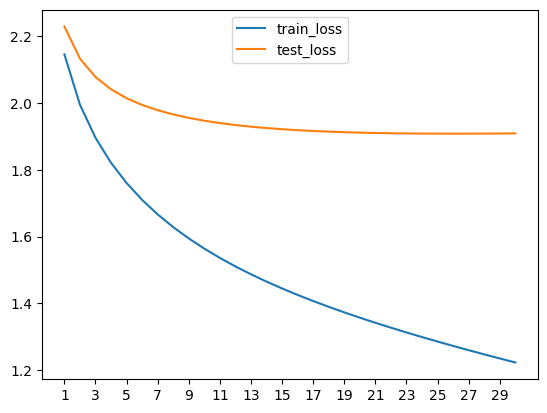

In [8]:
import matplotlib.pyplot as plt
x = [i + 1 for i in range(num_epochs)]
plt.plot(x, train_loss, label='train_loss')
plt.plot(x, test_loss, label='test_loss')
leg = plt.legend(loc='upper center')
plt.xticks([i + 1 for i in range(0, num_epochs, 2)]) 
plt.show()